# Zero Noise Extrapolation (ZNE) in Qiskit Runtime

 - Teach the Researcher
 - 10a.m. June 14th, 2023
 - Ian Hincks @ IBM

##### Hidden imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["font.size"] = 10
mpl.rcParams["figure.dpi"] = 140

## Introduction to Richardson Extrapolation 

As an example, consider the function

$$
f(x) = e^{-1 - x} \sin(-1 - 5 x)
$$

and suppose we wish to find the value of $f'(0)$. 

This example is for illustrative purposes; the derivative is easy to compute, or alternatively, any scientific library could approximate it easily. Instead, we will use this example to briefly introduce Richardson extrapolation.

Plotting the function, we can see that the slope at zero is negative, and we might eye-ball it to be about -0.5.

Text(0, 0.5, 'f(x)')

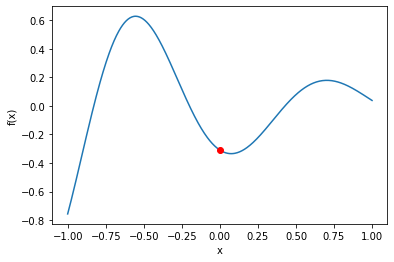

In [2]:
def f(x):
    return np.exp(-1 - x) * np.sin(-1 - 5*x)

xs = np.linspace(-1, 1, 500)
plt.plot(xs, f(xs))
plt.plot([0], [f(0)], 'o', color='r')

plt.xlabel("x")
plt.ylabel("f(x)")

To begin, let's approximate $f'(0)$ with the simplest finite difference formula:

$$
f'(x) = \Delta(x,h) + O(h) = \frac{f(x + h) - f(x)}{h} + O(h)
$$

We plot this, and show how close to the true value we would get if we used $\Delta(0, 0.1)$ or $\Delta(0, 0.3)$ to estimate $f'(0)$. Notice that the second doesn't even get the sign right.

**Let's pretend that $\Delta(0, h)$ is a black box function, and the only thing related to $f$ that we're allowed to probe. Moreover, invoking $\Delta(0,h)$ is expensive.**

Text(0, 0.5, '$\\Delta(0, h)$')

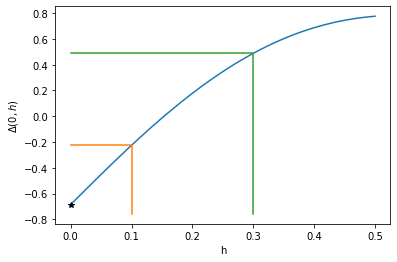

In [3]:
def df(x, h):
    return (f(x + h) - f(x)) / h

hs = np.linspace(0.001, 0.5, 500)
plt.plot(hs, df(0, hs))
plt.plot([0], df(0, 0.00001), "*", c='k')

min_y = plt.gca().get_ylim()[0]
for h in [0.1, 0.3]:
    plt.plot([0, h, h], [df(0, h), df(0,h), min_y])

plt.xlabel("h")
plt.ylabel(r"$\Delta(0, h)$")

The key intuition is that by extrapolating these two fairly bad estimates of $f'(0)$, we can get a guess a better estimate. Below, we use a **linear etrapolation using only two evaluation**s of $\Delta(0,h)$.

In [11]:
min_y

-0.7784925139454393

Text(0, 0.5, '$\\Delta(0, h)$')

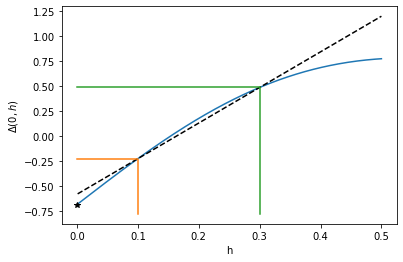

In [20]:
plt.plot(hs, df(0, hs))
plt.plot([0], df(0, 0.00001), "*", c='k')
plt.plot(hs, (hs - 0.1) * (df(0,0.3) - df(0,0.1))/0.2 + df(0,0.1), c="k", ls="--")

min_y = plt.gca().get_ylim()[0]
for h in [0.1, 0.3]:
    plt.plot([0, h, h], [df(0, h), df(0,h), min_y])
    # plt.plot([0, h], [df(0, h), min_y])

plt.xlabel("h")
plt.ylabel(r"$\Delta(0, h)$")


One of the simplest form of Richardson extrapolation assumes that the quantity of interest has a series expansion of the form
$$
A(h)= A^\star + O(h^n)
$$

It is easy to expand the following "Richardson extrapolation"
$$
R(h, c) = \frac{A(h\cdot c) / c ^n - A(h)}{1/c^n - 1}
$$
which **uses two evaluations of $A(h)$, one at $h$** and one at $c\cdot h$ for some fixed $h,c$, to see that it produces an estimate of $A^\star$ with error $O(h^{n+1})$.

In our current example,

$$
A(h) = \Delta(0, h)
$$

and for various **stretch factors** $c$ we have

Text(0, 0.5, '$\\Delta(0, h)$')

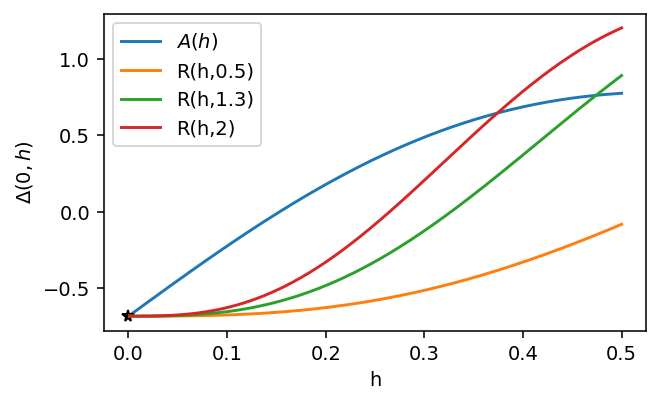

In [69]:
def a(h):
    return df(0, h)

def r(h, c, n=1):
    return (a(h * c) / c**n - a(h)) / (1 / c**n - 1)

hs = np.linspace(0.001, 0.5, 500)
plt.plot(hs, a(hs), label="$A(h)$")
plt.plot([0], df(0, 0.00001), "*", c='k')

for t in [0.5, 1.3, 2]:
    plt.plot(hs, r(hs, t), label=f"R(h,{t})")

plt.legend()
plt.xlabel("h")
plt.ylabel(r"$\Delta(0, h)$")

## Zero Noise Extrapolation for Quantum Error Mitigation

You can imagine a direct analog to the section above where the quantity of interest is some observable of the final state of a quantum circuit, where the deviation from the ideal value occurs because of quantum error:

$$
\langle \tilde{A} \rangle_h = \langle A \rangle + O(h)
$$

where

$$
\langle A \rangle = \operatorname{Tr} \rho(T) A
$$

The idea of Zero Noise extrapolation is to **artificially inject noise into the system at known multipliers of the intrinsic noise**.

Then, **extrapolation is used to infer the zero-noise limit** of the quantity of interest, justified by tools like Richardson extrapolation.

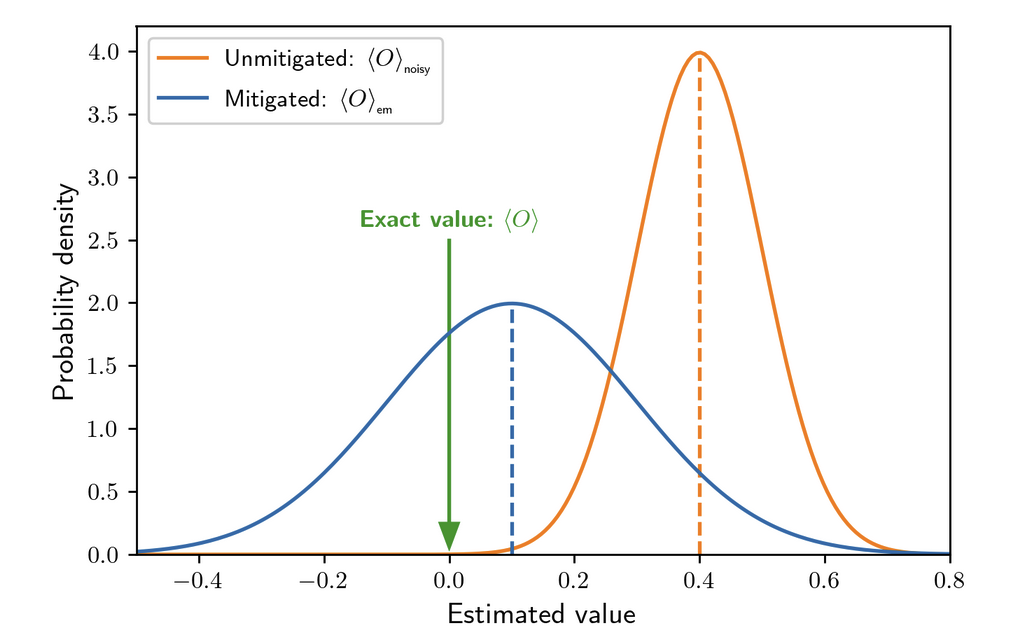

### 1. Pulse Stretching

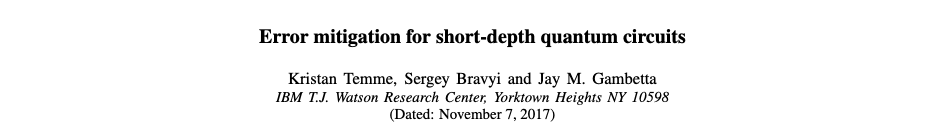

In this theory/simulation work, assumptions are made about the noise model such that simply lengthening the duration of a (tuned-up) pulse causes the injection of a proportional amount of error.

$$
\frac{\partial}{\partial t}\rho(t) = -i[H(t), \rho(t)] + \lambda \mathcal{L}(\rho(t))
$$

The power series

$$
\langle A \rangle_{K, \lambda}
= \langle A \rangle
+ \sum_{k=1}^n a_k \lambda^k
+ O(\lambda^{n+1})
$$

can be derived, from which an $n^\text{th}$ order extrapolation can be made to infer $\langle A \rangle$.

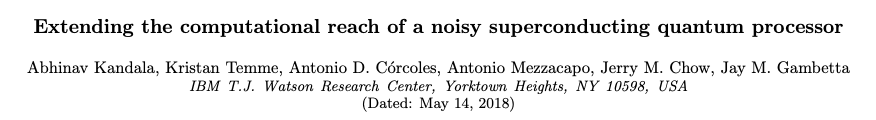



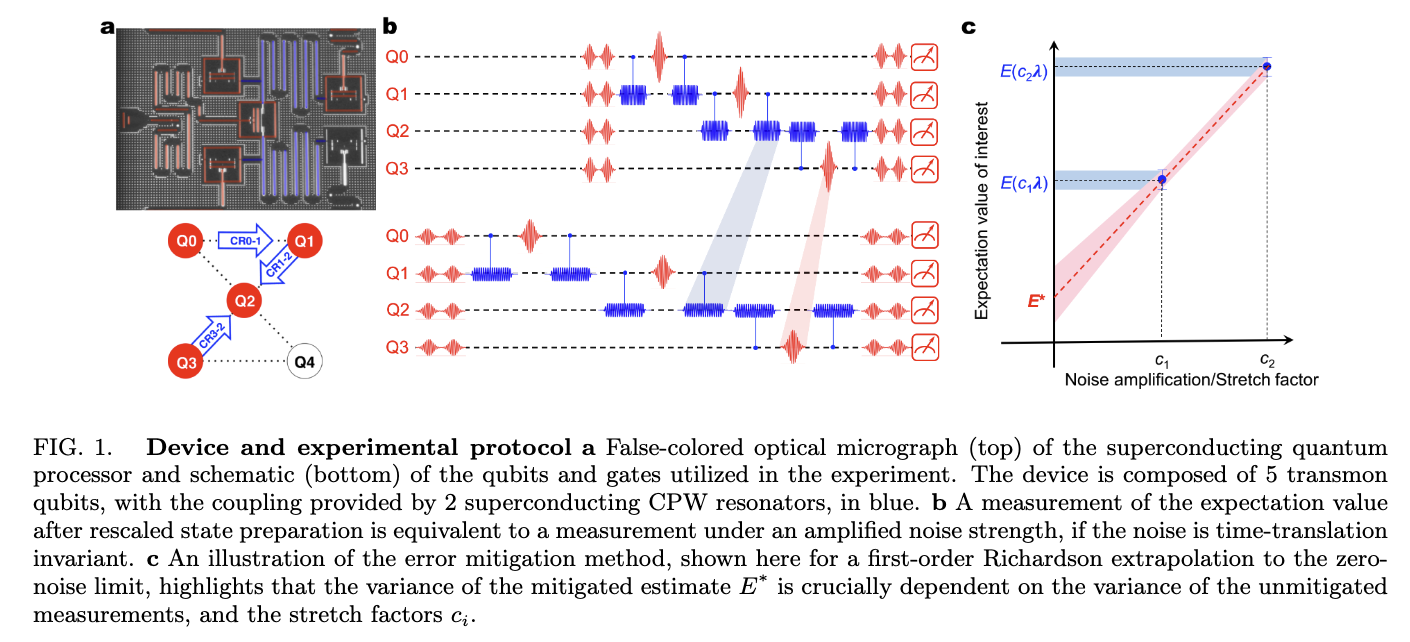

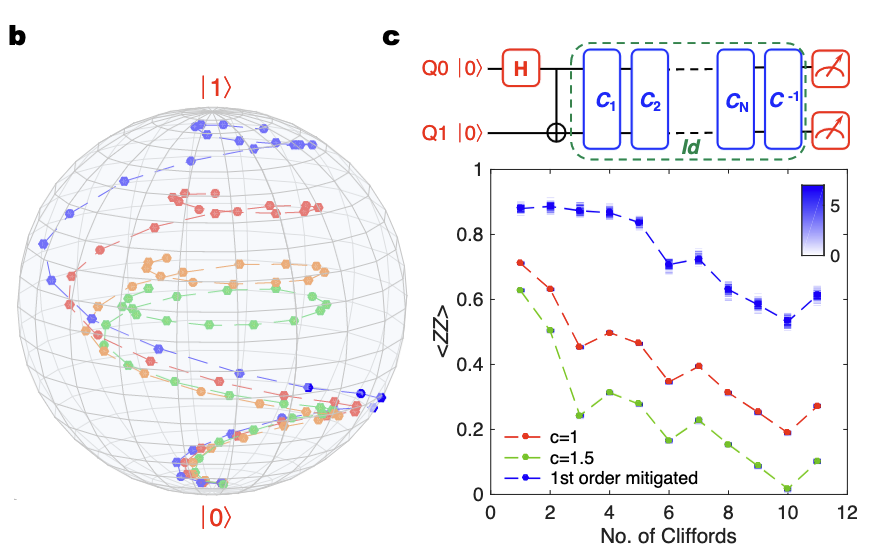

(https://arxiv.org/abs/2108.09197)
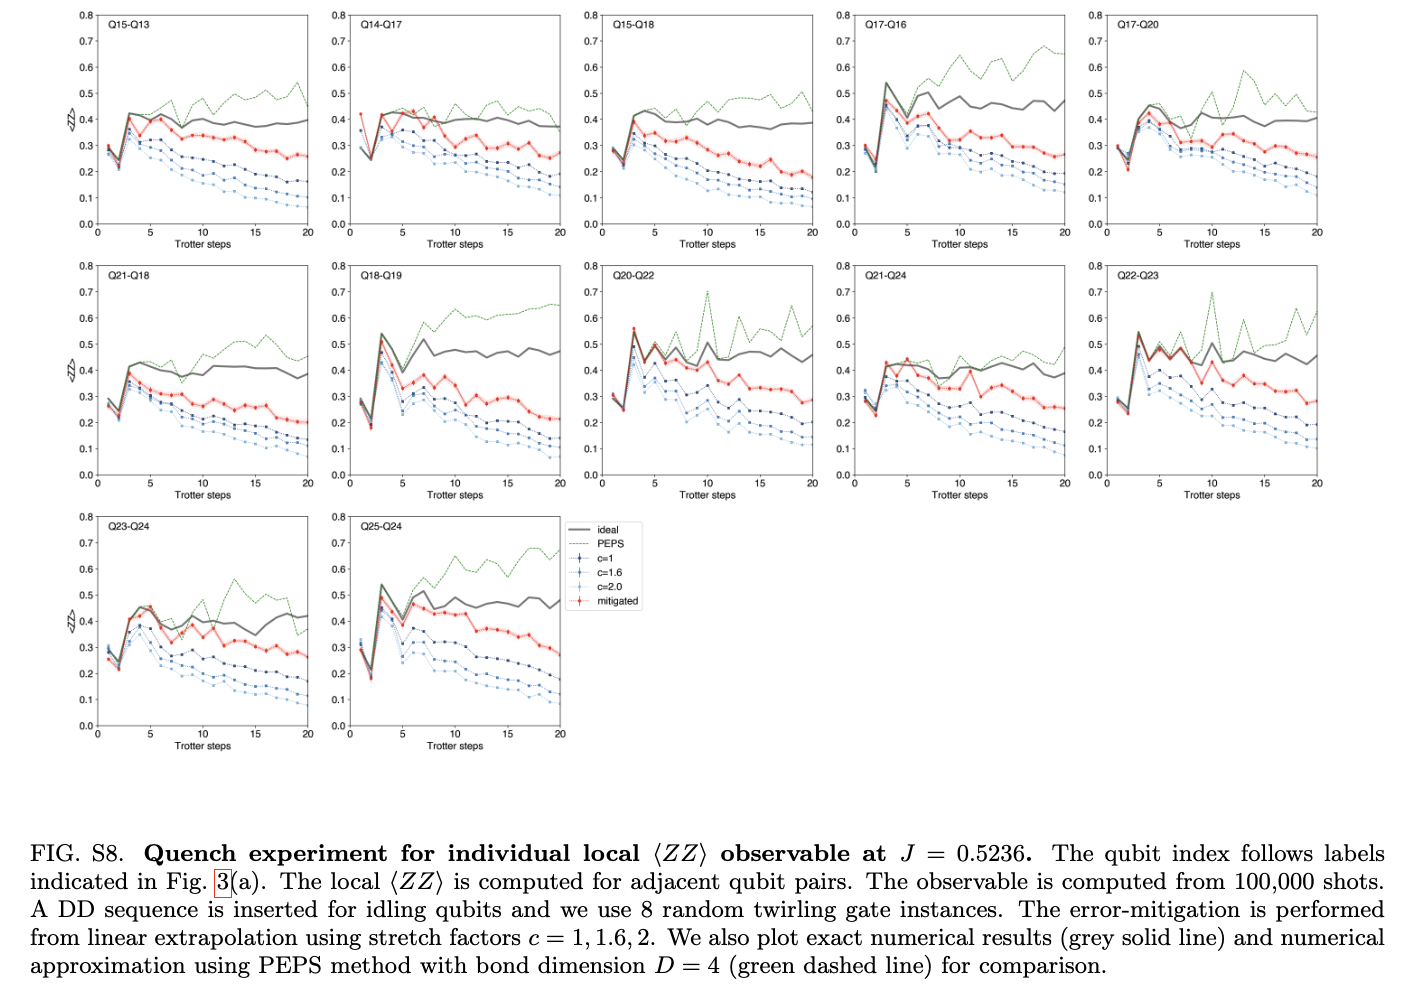

### 2. Gate Folding/Unitary Folding/Digital ZNE

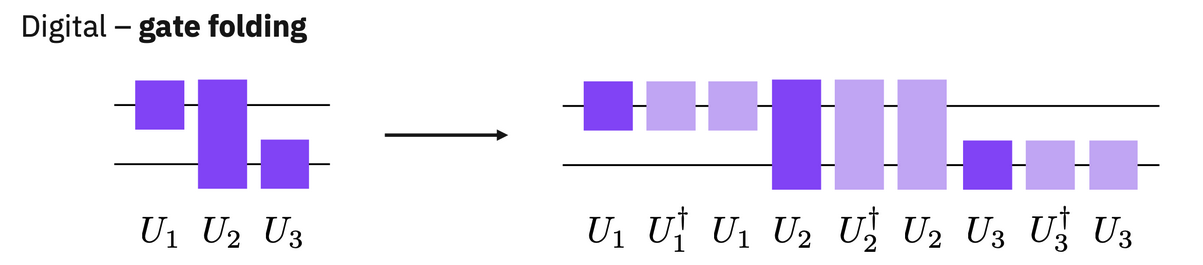

Advantage: Everything is done at the **circuit level**, so you can work with a single set of tuned-up gates.
Disadvantage: Naive implementations force scaling factors to be, e.g. odd integers, which cause very large error budget overhead.

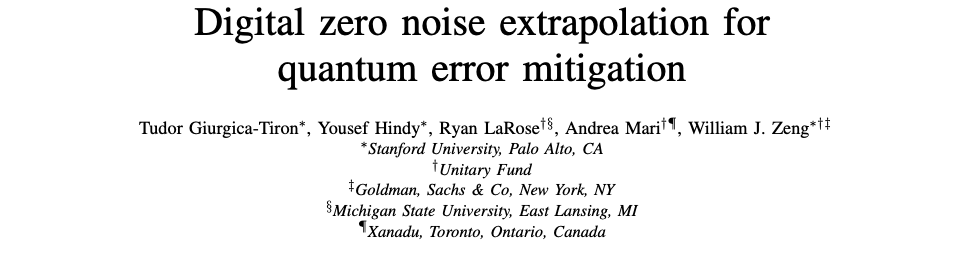

(from https://arxiv.org/abs/2005.10921)

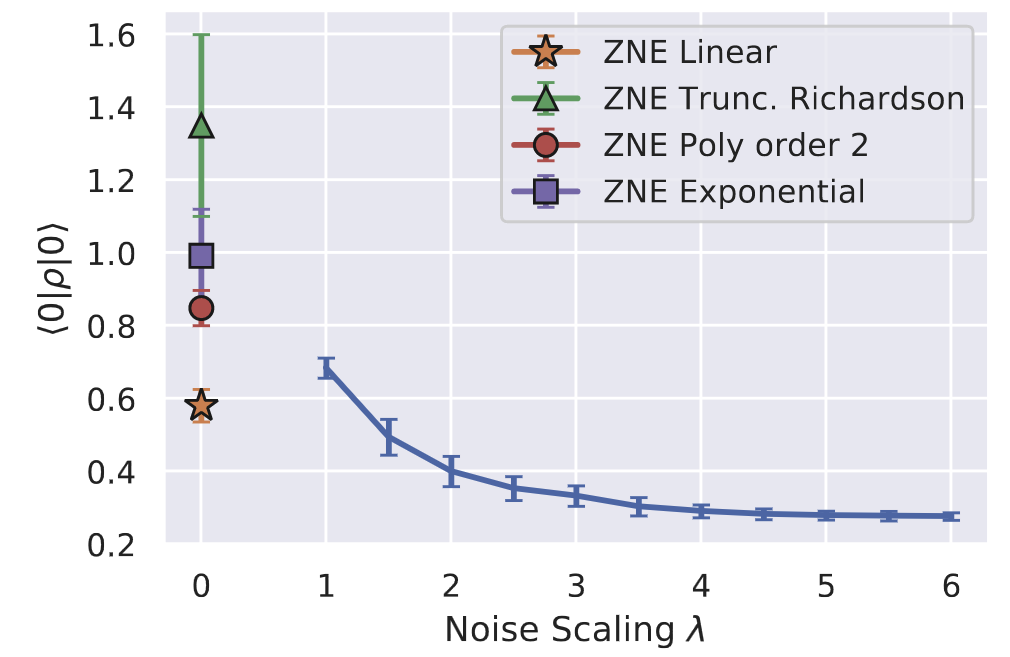

### 3. Other methods

## ZNE with the Qiskit Runtime Estimator

### The Estimator Primitive

`qiskit.primitives.base.BaseEstimator`
 - `qiskit.primitives.Estimator` reference implementation
 - `qiskit.primitives.BackendEstimator` implementation that works for any Backend
 - `qiskit_aer.primitives.Estimator` implementation that takes advantage of Aer
 - `qiskit_ibm_runtime.Estimator` <span style="color:blue">best implementation to use for real IBM backends</span>

In [24]:
import qiskit as qk
import qiskit.primitives

# create a circuit that prepares the bell state 00+11
bell = qk.QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)

# create a circuit that prepares 01+10
zero_quantum = qk.QuantumCircuit(2)
zero_quantum.h(0)
zero_quantum.cx(0, 1)
zero_quantum.x(1)

# create a circuit that prepares 00+01+10+11
uniform = qk.QuantumCircuit(2)
uniform.h(0)
uniform.h(1)

# we wish to measure <ZZ> on each circuit
obs = qk.quantum_info.PauliList(["ZZ"])

# we can use any Estimator
estimator = qk.primitives.Estimator()
estimator.run([bell, zero_quantum, uniform], [obs] * 3).result()

EstimatorResult(values=array([ 1., -1.,  0.]), metadata=[{}, {}, {}])

In [25]:
obs

PauliList(['ZZ'])

### Runtime Mitigation Framework Overview

The `qiskit_ibm_runtime` primitives have options to enable and disable error mitigation techniques. The coarsest action that can be taken is to modify the resiliance level.

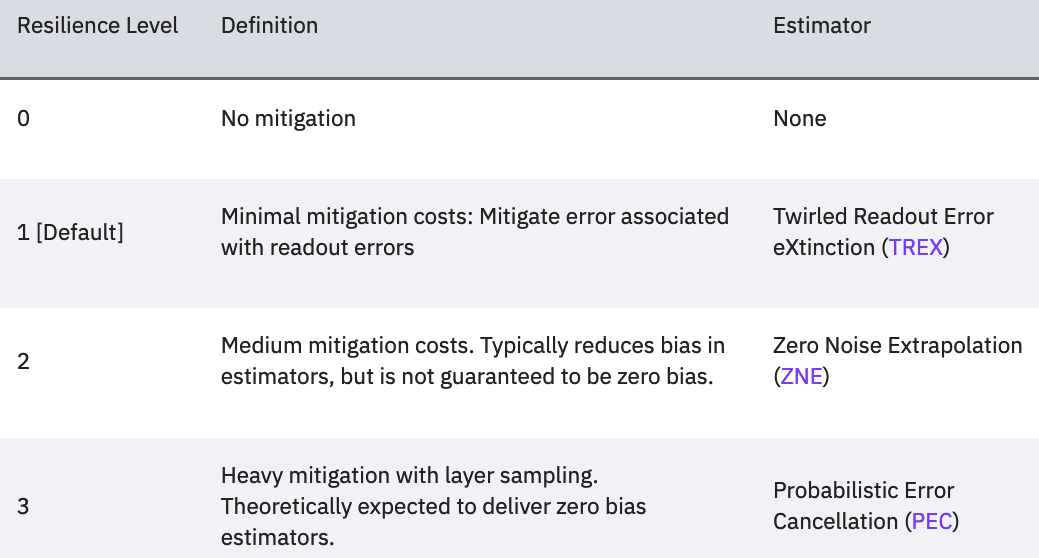

`options.resilience.noise_amplifier`
 - `"TwoQubitAmplifier"` Amplifies noise of all two qubit gates by performing local gate folding.
 - `"CxAmplifier"` Amplifies noise of all CNOT gates by performing local gate folding.
 - `"LocalFoldingAmplifier"` Amplifies noise of all gates by performing local gate folding.
 - `"GlobalFolderAmplifier"` Amplifies noise of the input circuit by performing global folding of the entire input circuit.
 
`options.resilience.noise_factors`
 - E.g. `[1, 3, 5]`
 
`options.resilience.extrapolator`
 - `"LinearExtrapolator"`
 - `"QuadraticExtrapolator"`
 - `"CubicExtrapolator"`
 - `"QuarticExtrapolator"`

### Warm Up

In [1]:
import qiskit as qk
import qiskit_aer as qa
import qiskit_ibm_runtime as qr
import numpy as np
import matplotlib.pyplot as plt

import qiskit.providers.fake_provider

service = qr.QiskitRuntimeService()

c:\Users\kimje\anaconda3\envs\qiskit_JW\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: skit-terra is an invalid version and will not be supported in a future release
  warnings.warn(


First we create a test circuit with a single parameter.

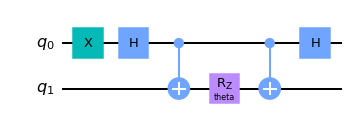

In [2]:
theta = qk.circuit.Parameter('theta')

circuit = qk.QuantumCircuit(2)
circuit.x(0)
circuit.h(0)
circuit.cx(0, 1)
circuit.rz(theta, 1)
circuit.cx(0, 1)
circuit.h(0)

circuit.draw("mpl")

For many values of the parameter, we wish to measure the following observable:

In [3]:
obs = qk.quantum_info.PauliList(["ZZ"])

We will sweep the parametric phase through the following 50 values.

In [4]:
phases = np.linspace(0, 2*np.pi, 50)
# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

Invoke the estimator using resilience levels 0, 1, and 2.

In [5]:
# Make a noise model
fake_backend = qk.providers.fake_provider.FakeManila()
noise_model = qa.noise.NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = qr.Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
options.execution.shots = 8000
options.optimization_level = 0


with qr.Session(service=service, backend="ibmq_qasm_simulator"):
    sampler = qr.Estimator(options=options)
    job0 = sampler.run(
        circuits=[circuit] * len(phases),
        observables=[obs] * len(phases),
        parameter_values=individual_phases,
        resilience_level=0
    )
    
    sampler = qr.Estimator(options=options)
    job1 = sampler.run(
        circuits=[circuit] * len(phases),
        observables=[obs] * len(phases),
        parameter_values=individual_phases,
        resilience_level=1
    )

    sampler = qr.Estimator(options=options)
    job2 = sampler.run(
        circuits=[circuit] * len(phases),
        observables=[obs] * len(phases),
        parameter_values=individual_phases,
        resilience_level=2
    )

exp0 = job0.result().values
exp1 = job1.result().values
exp2 = job2.result().values

What we see is that Level 2 slightly outperforms unmitigated, and Level 1 outperforms both of them. This is because Level 1 uses **measurement error mitigation** (via T-REX), but Level 2 does not. For such a **short-depth circuit, measurement errors dominate**, so that this is surprising. Morover, measurement error mitigation is generally a simpler problem without as many caveats as ZNE.

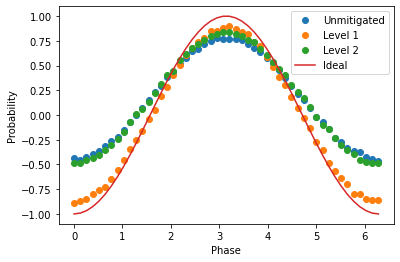

In [6]:
plt.plot(phases, exp0, 'o', label='Unmitigated')
plt.plot(phases, exp1, 'o', label='Level 1')
plt.plot(phases, exp2, 'o', label='Level 2')
plt.plot(phases, -np.cos(phases,), label='Ideal')
plt.xlabel('Phase')
plt.ylabel('Probability')
plt.legend()

### Deeper Circuit

We can try and make the previous example more interesting by making the circuit deeper. To this end, we simply repeat the middle piece that accumulates phase between $|00\rangle$ and $|11\rangle$.

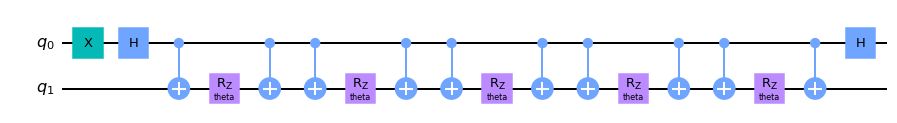

In [8]:
theta = qk.circuit.Parameter('theta')

reps = 5

circuit = qk.QuantumCircuit(2)
circuit.x(0)
circuit.h(0)
for _ in range(reps):
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
circuit.h(0)

circuit.draw("mpl")

We now perform the same experiment, this time trying quadratic extrapolation.

In [9]:
# Make a noise model
fake_backend = qk.providers.fake_provider.FakeManila()
noise_model = qa.noise.NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = qr.Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
options.execution.shots = 8000
options.optimization_level = 0
options.resilience.noise_amplifier = "CxAmplifier"
options.resilience.extrapolator = "QuadraticExtrapolator"


phases = np.linspace(0, 2*np.pi / reps, 50)
# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]


with qr.Session(service=service, backend="ibmq_qasm_simulator"):
    sampler = qr.Estimator(options=options)
    job0 = sampler.run(
        circuits=[circuit] * len(phases),
        observables=[obs] * len(phases),
        parameter_values=individual_phases,
        resilience_level=0
    )
    
    # include the noise model with M3
    sampler = qr.Estimator(options=options)
    job1 = sampler.run(
        circuits=[circuit] * len(phases),
        observables=[obs] * len(phases),
        parameter_values=individual_phases,
        resilience_level=1        
    )

    # include the noise model with M3
    sampler = qr.Estimator(options=options)
    job2 = sampler.run(
        circuits=[circuit] * len(phases),
        observables=[obs] * len(phases),
        parameter_values=individual_phases,
        resilience_level=2
    )

exp0 = job0.result().values
exp1 = job1.result().values
exp2 = job2.result().values

In this case, the sinusoid resulting from Level 2 (ie ZNE) has the highest contrast, and so in this regards outperforms Level 1.

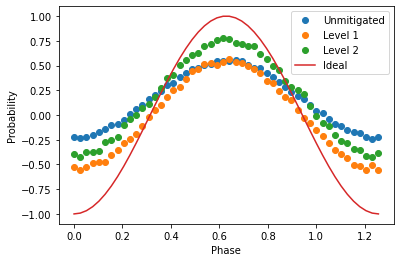

In [10]:
plt.plot(phases, exp0, 'o', label='Unmitigated')
plt.plot(phases, exp1, 'o', label='Level 1')
plt.plot(phases, exp2, 'o', label='Level 2')
plt.plot(phases, -np.cos(reps * phases), label='Ideal')
plt.xlabel('Phase')
plt.ylabel('Probability')
plt.legend()

We can get a bit more insight by digging into the metadata. To each circuit, there corresponds a set of metadata that we can examine. For example, here is the metadata associated with the first circuit:

In [16]:
job2.result()

EstimatorResult(values=array([-0.3900625 , -0.41984375, -0.3745625 , -0.3720625 , -0.36903125,
       -0.27509375, -0.2544375 , -0.21828125, -0.10396875, -0.03628125,
        0.00221875,  0.0706875 ,  0.1145625 ,  0.1824375 ,  0.27403125,
        0.37284375,  0.40240625,  0.5065    ,  0.5555    ,  0.60740625,
        0.62896875,  0.69296875,  0.71740625,  0.75828125,  0.7748125 ,
        0.76703125,  0.7289375 ,  0.7200625 ,  0.6989375 ,  0.6985    ,
        0.61209375,  0.5679375 ,  0.4943125 ,  0.4594375 ,  0.34715625,
        0.2820625 ,  0.25565625,  0.20875   ,  0.094875  , -0.0129375 ,
       -0.084     , -0.109375  , -0.2015    , -0.26221875, -0.28075   ,
       -0.33959375, -0.3561875 , -0.41821875, -0.4264375 , -0.3796875 ]), metadata=[{'zne': {'noise_amplification': {'noise_amplifier': "<CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [-0.22025, 0.01325, 0.10525], 'variance

In [17]:
job2.result().metadata[0]

{'zne': {'noise_amplification': {'noise_amplifier': "<CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
   'noise_factors': [1, 3, 5],
   'values': [-0.22025, 0.01325, 0.10525],
   'variance': [0.9514899375, 0.9998244375, 0.9889224375],
   'shots': [8000, 8000, 8000]},
  'extrapolation': {'extrapolator': 'QuadraticExtrapolator'}}}

From it, we can extract the expectation values at each amplification level.

Text(0.5, 0, 'Phase')

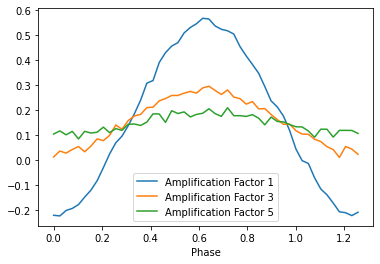

In [58]:
means = np.empty((len(phases), 3))
for idx, metadata in enumerate(job2.result().metadata):
    means[idx, :] = metadata["zne"]["noise_amplification"]["values"]
    
for idx, amplification in enumerate([1, 3, 5]):
    plt.plot(phases, means[:, idx], label=f"Amplification Factor {amplification}")

plt.legend()
plt.xlabel("Phase")

### Trotterized Circuit Demo

In [18]:
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

service = QiskitRuntimeService()

In [19]:
backend_simulator = "ibmq_qasm_simulator"
backend = "ibmq_quito"

qubits = 4
trotter_layer = QuantumCircuit(qubits)
trotter_layer.rx(0.1, range(qubits))
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.rz(-0.2, [1, 3])
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.cx(1, 2)
trotter_layer.rz(-0.2, 2)
trotter_layer.cx(1, 2)

num_steps = 6
trotter_circuit_list = []
for i in range(1, num_steps):
    trotter_circuit = QuantumCircuit(qubits)
    for _ in range(i):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    trotter_circuit_list.append(trotter_circuit)
    print(f"Trotter circuit with {i} Trotter steps")
    display(trotter_circuit.draw(fold=-1))

obs = SparsePauliOp("Z" * qubits)
obs_list = [obs] * len(trotter_circuit_list)

Trotter circuit with 1 Trotter steps


┌─────────┐                                            
q_0: ┤ Rx(0.1) ├──■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘

Trotter circuit with 2 Trotter steps


┌─────────┐                      ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 3 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 4 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 5 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

In [20]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    print(job_sim.result())

expvals_ideal = job_sim.result().values
expvals_ideal_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_sim.result().metadata
]
std_error_ideal = np.sqrt(expvals_ideal_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ci7ae15ejm3lf1fvk010', 'estimator')>>
EstimatorResult(values=array([0.98 , 0.92 , 0.848, 0.77 , 0.612]), metadata=[{'variance': 0.03960000000000008, 'shots': 1000}, {'variance': 0.15359999999999996, 'shots': 1000}, {'variance': 0.28089600000000003, 'shots': 1000}, {'variance': 0.4071, 'shots': 1000}, {'variance': 0.625456, 'shots': 1000}])


In [22]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No error mitigation

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job.job_id)
    print(job.result())

expvals_unmit = job.result().values
expvals_unmit_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job.result().metadata
]
std_error_unmit = np.sqrt(expvals_unmit_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ci7aeeo7s2lildoajd5g', 'estimator')>>


RuntimeJobFailureError: "Unable to retrieve job result. 'INTERNAL ERROR'"

In [ ]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No error mitigation

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job.job_id)
    print(job.result())

expvals_zne = job.result().values
expvals_zne_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job.result().metadata
]
std_error_zne = np.sqrt(expvals_zne_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ci4r2qvhmv10icss7ea0', 'estimator')>>
EstimatorResult(values=array([0.714, 0.566, 0.47 , 0.348, 0.318]), metadata=[{'variance': 0.4902040000000001, 'shots': 1000}, {'variance': 0.6796440000000001, 'shots': 1000}, {'variance': 0.7791, 'shots': 1000}, {'variance': 0.878896, 'shots': 1000}, {'variance': 0.898876, 'shots': 1000}])


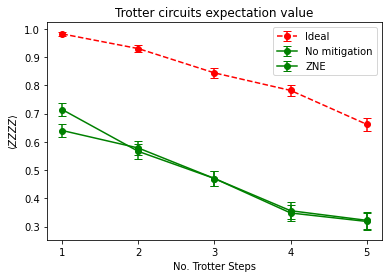

In [ ]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation",
)
plt.errorbar(
    range(1, num_steps),
    expvals_zne,
    std_error_zne,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="blue",
    label="ZNE",
)


plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

### Pitfalls

Out-of-model error:

 - E.g. Stochastic errors behave differently than coherent errors
 - These errors are not known a priori

Extrapolating from pure noise:

 - Unlike the Richardson Extrapolation example at the top, we eventually end up completely in the noise with sufficiently large amplification factors
 
Mitigation methods work best in tandem

### Coming Soon!

Development on mitigation schemes is under very active development, expect a continuous stream of improvements!

More options:

 - Combining ZNE with measurement error mitigation (TREX)
 - Combining ZNE with noise tailoring techniques (Pauli Twirling)
 - Better coordination with DD
 - More transparency about which circuits were actually run